In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

## Data Exploration

In [57]:
df = pd.read_csv("../EyeTrackingTest/0_2.txt", delimiter=",").iloc[:, :-1]

In [58]:
df.head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z
0,638000599197054286,179618,13094,-0.038940,0.014771,0.999130,-0.017029,0.027435,0.999466,0.038779,0.154808,0.987183
1,638000599197134289,179626,13095,-0.039474,0.015640,0.999085,-0.019257,0.026459,0.999451,0.038787,0.154899,0.987169
2,638000599197214285,179634,13095,-0.039642,0.016037,0.999085,-0.020264,0.026840,0.999420,0.038787,0.154899,0.987169
3,638000599197304286,179643,13096,-0.039429,0.016312,0.999085,-0.021408,0.026138,0.999420,0.038862,0.155148,0.987127
4,638000599197384285,179651,13097,-0.038757,0.015961,0.999115,-0.021637,0.025604,0.999435,0.038573,0.155322,0.987111


In [59]:
labelx = []
labely = []
labelz = []
for i in range(df.shape[0] - 1):
    label_row = df.iloc[i + 1]
    labelx.append(label_row["forward.x"])
    labely.append(label_row["forward.y"])
    labelz.append(label_row["forward.z"])
    
df = df.iloc[:-1, :]
df["label.x"] = labelx
df["label.y"] = labely
df["label.z"] = labelz
df.head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,638000599197054286,179618,13094,-0.038940,0.014771,0.999130,-0.017029,0.027435,0.999466,0.038779,0.154808,0.987183,0.038787,0.154899,0.987169
1,638000599197134289,179626,13095,-0.039474,0.015640,0.999085,-0.019257,0.026459,0.999451,0.038787,0.154899,0.987169,0.038787,0.154899,0.987169
2,638000599197214285,179634,13095,-0.039642,0.016037,0.999085,-0.020264,0.026840,0.999420,0.038787,0.154899,0.987169,0.038862,0.155148,0.987127
3,638000599197304286,179643,13096,-0.039429,0.016312,0.999085,-0.021408,0.026138,0.999420,0.038862,0.155148,0.987127,0.038573,0.155322,0.987111
4,638000599197384285,179651,13097,-0.038757,0.015961,0.999115,-0.021637,0.025604,0.999435,0.038573,0.155322,0.987111,0.038459,0.155397,0.987103


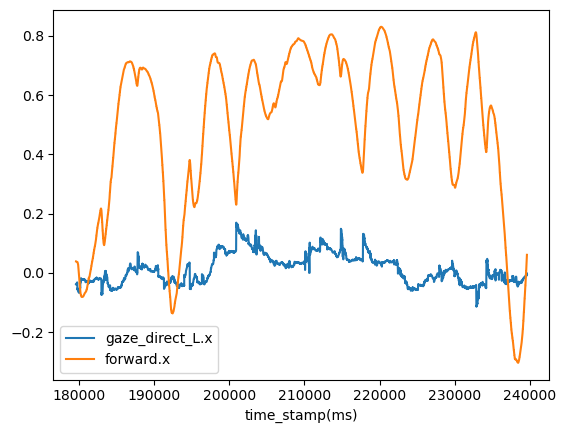

In [60]:
df.plot(x="time_stamp(ms)", y=["gaze_direct_L.x", "forward.x"])
plt.show()

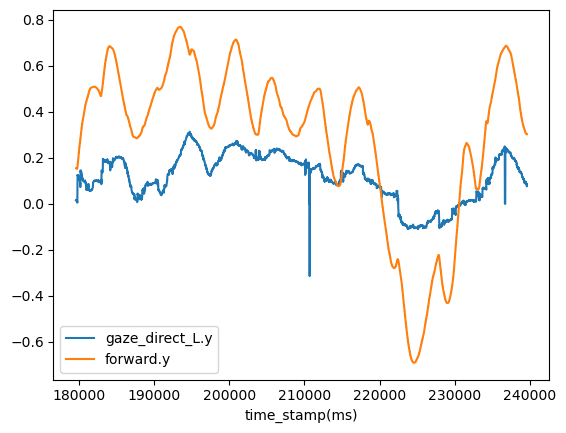

In [61]:
df.plot(x="time_stamp(ms)", y=["gaze_direct_L.y", "forward.y"])
plt.show()

In [7]:
X = df.iloc[:, 3:-3].to_numpy()
y = df.iloc[:, -3:].to_numpy()

print(X.shape, y.shape)

(7200, 9) (7200, 3)


In [8]:
X_train = Variable(torch.Tensor(X[:6000, :]))
X_test = Variable(torch.Tensor(X[6000:, :]))

y_train = Variable(torch.Tensor(y[:6000, :]))
y_test = Variable(torch.Tensor(y[6000:, :]))

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

torch.Size([6000, 9]) torch.Size([1200, 9])
torch.Size([6000, 3]) torch.Size([1200, 3])


In [9]:
X_train = torch.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = torch.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

print(X_train.shape, X_test.shape)

torch.Size([6000, 1, 9]) torch.Size([1200, 1, 9])


## LSTM Model

In [10]:
class CustomLSTM(nn.Module):
    def __init__(self):
        super(CustomLSTM, self).__init__()
        self.num_classes = 3
        self.num_layers = 1
        self.input_size = 9
        self.hidden_size = 9
        
        self.lstm = nn.LSTM(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Tanh(),
            nn.Linear(self.hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, self.num_classes)
        )
    
    def forward(self, x, h_0=None, c_0=None):
        if h_0 is None:
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(torch.device("cuda"))
        if c_0 is None:
            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(torch.device("cuda"))
        
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        _hn = hn.view(-1, self.hidden_size)
        out = self.fc(_hn)
        out = nn.functional.normalize(out)
        return out, hn, cn

In [11]:
num_epochs = 20
learning_rate = 0.001
criterion = torch.nn.MSELoss()

device = torch.device("cuda")

lstm = CustomLSTM().to(device)
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

## Training Loop and Results

In [81]:
torch.autograd.set_detect_anomaly(True)
X_train = X_train.to(device)
y_train = y_train.to(device)
for epoch in range(10):
    optimizer.zero_grad()
    instance = X_train[0:1, 0:1, :]
    #print(instance)
    hn = None
    cn = None
    loss = 0
    for i in range(X_train.shape[0]):
        pred, hn, cn = lstm(instance, hn, cn)
        loss += criterion(pred, y_train[i:i+1])
        if i < X_train.shape[0] - 1:
            l_pred = nn.functional.normalize(torch.reshape(X_train[i+1,0,6:9] + X_train[i+1,0,0:3] - pred[0], (1,3)))
            r_pred = nn.functional.normalize(torch.reshape(X_train[i+1,0,6:9] + X_train[i+1,0,3:6] - pred[0], (1,3)))
            instance = torch.reshape(torch.cat((l_pred, r_pred, pred), axis=1), (1,1,9))
        
    loss.backward()
    optimizer.step()
    
    #if epoch % 1000 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 60.52122
Epoch: 1, loss: 59.94902
Epoch: 2, loss: 59.36596
Epoch: 3, loss: 58.91333
Epoch: 4, loss: 58.25537
Epoch: 5, loss: 57.89979
Epoch: 6, loss: 57.65654
Epoch: 7, loss: 57.58032
Epoch: 8, loss: 57.13350
Epoch: 9, loss: 57.27967


In [82]:
X = df.iloc[:, 3:-3].to_numpy()
y = df.iloc[:, -3:].to_numpy()

print(X.shape, y.shape)

(7200, 9) (7200, 3)


In [83]:
X = Variable(torch.Tensor(X))
y = Variable(torch.Tensor(y))

X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

In [84]:
train_predict, _, _ = lstm(X.to(device))
data_predict = np.array([X[0, 0, 6:9].data.numpy()])
data_predict = np.append(data_predict, train_predict.data.cpu().numpy(), axis=0)

dataY_plot = np.array([X[0, 0, 6:9].data.numpy()])
dataY_plot = np.append(dataY_plot, y.data.numpy(), axis=0)
print(data_predict.shape, dataY_plot.shape)

(7201, 3) (7201, 3)


In [85]:
data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lstm(instance.to(device), hn, cn)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

(7201, 3)


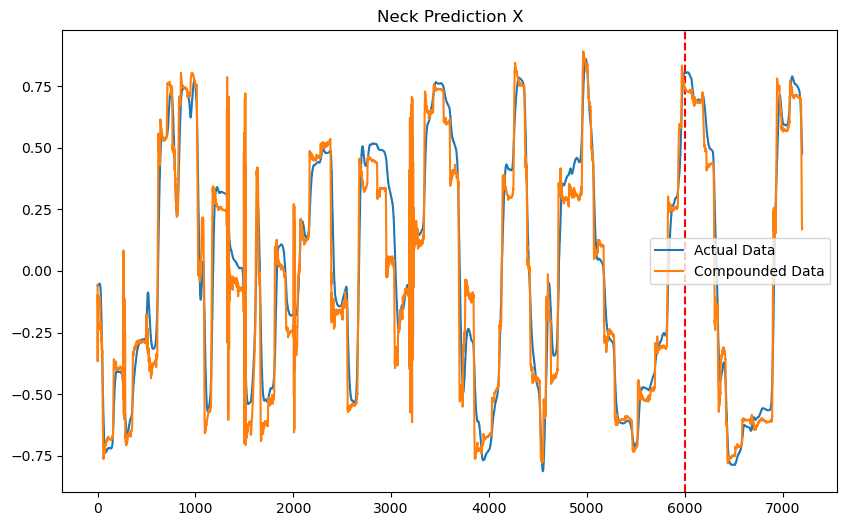

In [86]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 0], label="Actual Data")
#plt.plot(data_predict[:, 0], label="Predicted Data")
plt.plot(data_compound[:, 0], label="Compounded Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

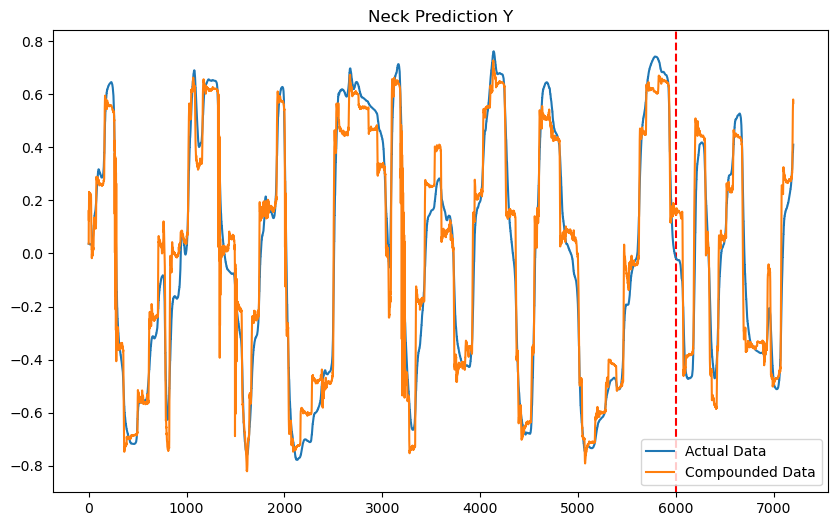

In [87]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 1], label="Actual Data")
#plt.plot(data_predict[:, 1], label="Predicted Data")
plt.plot(data_compound[:, 1], label="Compounded Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

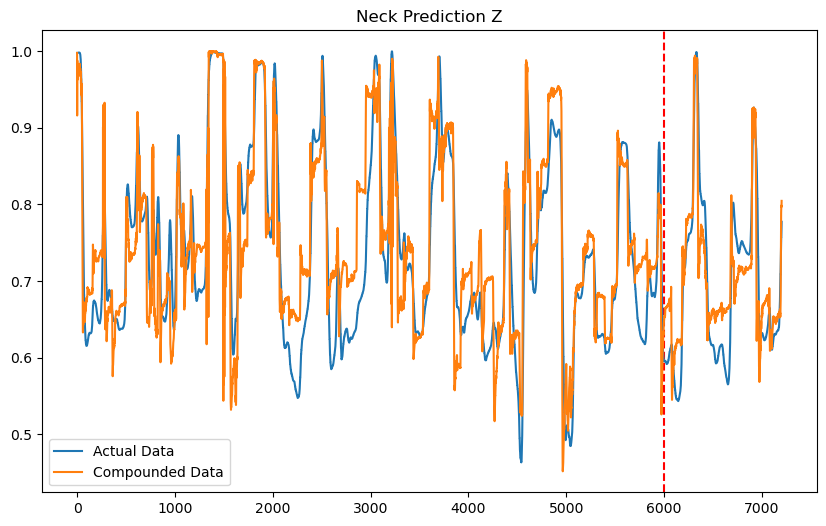

In [88]:
plt.figure(figsize=(10,6))
plt.axvline(x=6000, c='r', linestyle="--")

plt.plot(dataY_plot[:, 2], label="Actual Data")
#plt.plot(data_predict[:, 2], label="Predicted Data")
plt.plot(data_compound[:, 2], label="Compounded Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()

## Testing on New Series

In [92]:
df = pd.read_csv("../EyeTrackingTest/StandardSaccade_1.txt", delimiter=",").iloc[:, :-1]

In [93]:
labelx = []
labely = []
labelz = []
for i in range(df.shape[0] - 1):
    label_row = df.iloc[i + 1]
    labelx.append(label_row["forward.x"])
    labely.append(label_row["forward.y"])
    labelz.append(label_row["forward.z"])
    
df = df.iloc[:-1, :]
df["label.x"] = labelx
df["label.y"] = labely
df["label.z"] = labelz
df.head(5)

,time(100ns),time_stamp(ms),frame,gaze_direct_L.x,gaze_direct_L.y,gaze_direct_L.z,gaze_direct_R.x,gaze_direct_R.y,gaze_direct_R.z,forward.x,forward.y,forward.z,label.x,label.y,label.z
0,637986588384757883,38779,562,0.000595,0.158646,0.987320,0.042725,0.191894,0.980469,-0.058874,0.037112,0.997575,-0.059291,0.037051,0.997553
1,637986588384827882,38786,563,0.002823,0.153824,0.988083,0.047531,0.191437,0.980347,-0.059291,0.037051,0.997553,-0.059612,0.037082,0.997533
2,637986588384917880,38795,564,0.008652,0.153778,0.988052,0.047424,0.191635,0.980316,-0.059612,0.037082,0.997533,-0.059541,0.037053,0.997538
3,637986588384997884,38803,565,0.006210,0.155228,0.987854,0.044769,0.190186,0.980713,-0.059541,0.037053,0.997538,-0.059541,0.037053,0.997538
4,637986588385077884,38811,565,0.003616,0.155029,0.987900,0.047867,0.190018,0.980606,-0.059541,0.037053,0.997538,-0.059199,0.036881,0.997565


In [94]:
X = df.iloc[:, 3:-3].to_numpy()
y = df.iloc[:, -3:].to_numpy()

print(X.shape, y.shape)

(7200, 9) (7200, 3)


In [95]:
X = Variable(torch.Tensor(X))
y = Variable(torch.Tensor(y))

X = torch.reshape(X, (X.shape[0], 1, X.shape[1]))

(7201, 3)


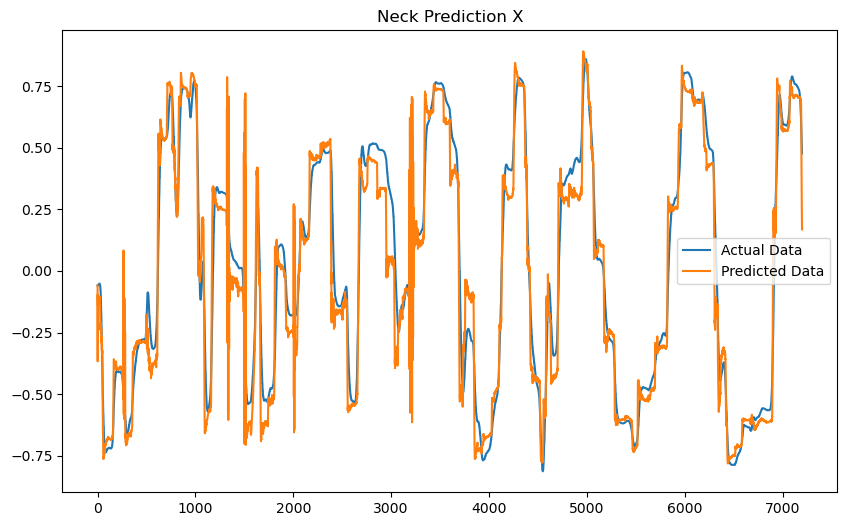

In [96]:
train_predict, _, _ = lstm(X.to(device))
data_predict = train_predict.data.cpu().numpy()
dataY_plot = y.data.numpy()

data_compound = [X[0, 0, 6:9].data.numpy()]
hn = None
cn = None
for i in range(X.size(0)):
    instance = X[i:i+1]
    pred, hn, cn = lstm(instance.to(device), hn, cn)
    pred = pred.data.cpu().numpy()
    cur = X[i, 0, 6:9].data.numpy()
    data_compound.append(pred[0])
    if i < X.size(0) - 1:
        X[i+1,0,0:3] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,0:3] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,3:6] = nn.functional.normalize(torch.reshape(X[i+1,0,6:9] + X[i+1,0,3:6] - torch.Tensor(pred[0]), (1,3))).view(-1,3)
        X[i+1,0,6] = pred[0,0].item()
        X[i+1,0,7] = pred[0,1].item()
        X[i+1,0,8] = pred[0,2].item()
data_compound = np.array(data_compound)
print(data_compound.shape)

plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 0], label="Actual Data")
plt.plot(data_compound[:, 0], label="Predicted Data")
plt.title("Neck Prediction X")
plt.legend()
plt.show()

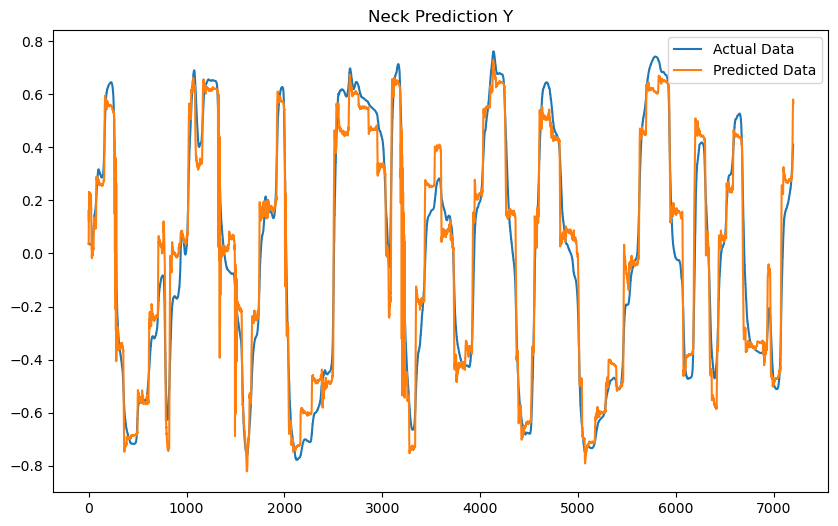

In [97]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 1], label="Actual Data")
plt.plot(data_compound[:, 1], label="Predicted Data")
plt.title("Neck Prediction Y")
plt.legend()
plt.show()

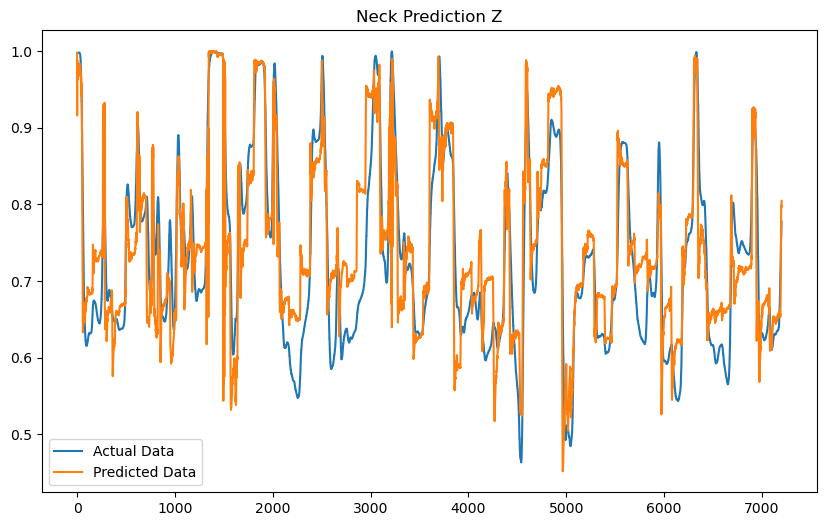

In [98]:
plt.figure(figsize=(10,6))

plt.plot(dataY_plot[:, 2], label="Actual Data")
plt.plot(data_compound[:, 2], label="Predicted Data")
plt.title("Neck Prediction Z")
plt.legend()
plt.show()